In [27]:
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm_notebook as tqdm
import pickle
import os
from typing import List, Dict
import seaborn as sns
sns.set_palette("colorblind")

In [28]:
os.chdir("/home/edgan/projects/sketchstore/java")

In [29]:
colormap = {
    "cooperative": "C0",
    "truncation": "C1",
    "pps": "C2",
    "random_sample": "C3",
    "dyadic_truncation": "C4",
    
    "cms_min": "C5",
    "kll": "C5",
    "low_discrep": "C6",
    "yahoo_mg": "C6",
}
markers = {
    "cooperative": "x",
    "truncation": "^",
    "pps": "s",
    "random_sample": "+",
    "dyadic_truncation": "<",
    
    "cms_min": "o",
    "kll": "o",
    "low_discrep": "1",
    "yahoo_mg": "1",
}
alg_display_name = {
    "cooperative": "Cooperative",
    "truncation": "Truncation",
    "pps": "PPS",
    "random_sample": "Uniform Sample",
    "dyadic_truncation": "Hierarchy",

    "cms_min": "CountMin Sketch",
    "kll": "KLL",
    "low_discrep": "Low Discrep",
    "yahoo_mg": "MisraGries",
}
data_display_name = {
    "l_caida_f": "CAIDA",
    "l_zipf_f": "Zipf",
    "l_mnetwork_f": "Service:Provider",
    "l_mos_f": "Service:OSBuild",
    "l_power_q": "Power",
    "l_uniform_q": "Uniform",
    "l_mrecords_q": "Service:Traffic",
}
def get_error_file(experiment_name):
    return os.path.join(
        "output/results/{}".format(experiment_name),
        "errors.csv"
    )

# Multi Dataset

In [30]:
def query_length_plot(
    experiment_name,
    sketch_names: List,
    item_agg="max",
    query_agg="mean",
    ax = None,
    absolute=False,
):
    e_combined = pd.read_csv(get_error_file(experiment_name))
    e_combined["e_norm"] = e_combined[item_agg] / e_combined["total"]
    if absolute:
        e_combined["e_norm"] = e_combined[item_agg]
    eg = e_combined.groupby(["sketch", "query_len"]).aggregate({
        "e_norm": ["mean", "std", "max", "count"],
    })
    eg["err"] = eg[("e_norm", query_agg)]
    eg["err_std"] = eg["e_norm", "std"] / np.sqrt(eg["e_norm", "count"])
    if ax is None:
        f = plt.figure(figsize=(6,4.5))
        ax = f.gca()
    for method in sketch_names:
        eg_cur = eg.loc[method]

        ax.errorbar(
            eg_cur.index,
            eg_cur["err"],
            yerr=eg_cur["err_std"],
            color=colormap[method],
            markersize=5,
            lw=.5,
        )
        ax.plot(
            eg_cur.index,
            eg_cur["err"],
            label=alg_display_name[method],
            marker=markers[method],
            color=colormap[method],
            markersize=5,
            fillstyle="none",
            lw=.5,
        )

        ax.set_xscale("log")
        ax.set_yscale("log")
#         ax.grid(axis="y", linestyle=(0, (2, 10)))
    return ax, eg

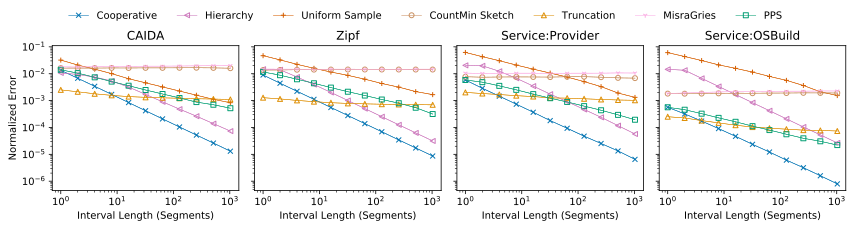

In [34]:
sketch_names = [
    "cooperative", 
    "dyadic_truncation", 
    "random_sample", 
    "cms_min", 
    "truncation", 
    "yahoo_mg",
    "pps"
]
sketch_size = 64
experiments = [
    "l_caida_f",
    "l_zipf_f",
    "l_mnetwork_f",
    "l_mos_f",
]

fig, axs = plt.subplots(figsize=(12,3), nrows=1, ncols=4, sharey=True, dpi=100)
plt.subplots_adjust(wspace=.1)

di = 0
for dataset_name in experiments:
    query_length_plot(
        dataset_name,
        sketch_names,
        item_agg="max",
        query_agg="mean",
        ax=axs[di],
        absolute=False,
    )
    axs[di].set_title(data_display_name[dataset_name])
    axs[di].set_xlabel("Interval Length (Segments)")
#     axs[di].yaxis.grid(lw=0.5,ls="-.")
    di += 1
    

axs[0].set_ylabel("Normalized Error")

fig.tight_layout()
lgd = axs[0].legend(frameon=False, loc='upper center', bbox_to_anchor=(2, 1.3), ncol=7)
fname = "output/plots/linear_freq.pdf"
fig.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

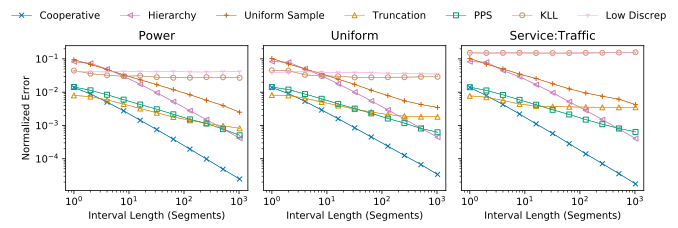

In [35]:
sketch_names = [
    "cooperative", 
    "dyadic_truncation", 
    "random_sample", 
    "truncation", 
    "pps",
    "kll",
    "low_discrep",
]
sketch_size = 64
experiments = [
    "l_power_q",
    "l_uniform_q",
    "l_mrecords_q",
]

fig, axs = plt.subplots(figsize=(9,3), nrows=1, ncols=3, sharey=True, dpi=100)
plt.subplots_adjust(wspace=.1)

di = 0
egs = []
for dataset_name in experiments:
    ax1, eg1 = query_length_plot(
        dataset_name,
        sketch_names,
        item_agg="max",
        query_agg="mean",
        ax=axs[di],
#         absolute=True
    )
    axs[di].set_title(data_display_name[dataset_name])
    axs[di].set_xlabel("Interval Length (Segments)")
#     axs[di].yaxis.grid(lw=0.5,ls="-.")
    egs.append(eg1)
    di += 1

axs[0].set_ylabel("Normalized Error")
# axs[0].set_ylim(10**-5, 1)

fig.tight_layout()
lgd = axs[0].legend(frameon=False, loc='upper center', bbox_to_anchor=(1.5, 1.3), ncol=7)
fname = "output/plots/linear_quant.pdf"
fig.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [25]:
eg = egs[2].reset_index()
eg[eg["query_len"]==1024].sort_values(["err"])

sketch query_len    e_norm                                 err  \
                                     mean       std       max count             
10        cooperative      1024  0.000018  0.000003  0.000039   500  0.000018   
21  dyadic_truncation      1024  0.000405  0.000056  0.000604   500  0.000405   
54                pps      1024  0.000485  0.000037  0.000568   500  0.000485   
65      random_sample      1024  0.002525  0.000424  0.003735   500  0.002525   
76         truncation      1024  0.003513  0.000050  0.003603   500  0.003513   
32                kll      1024  0.155878  0.014993  0.191316   500  0.155878   
43        low_discrep      1024  0.156950  0.026188  0.214845   500  0.156950   

         err_std  
                  
10  1.442856e-07  
21  2.500173e-06  
54  1.644977e-06  
65  1.898092e-05  
76  2.234478e-06  
32  6.705107e-04  
43  1.171151e-03

# Varying Space

In [96]:
def get_dyadic_size(s, granularity: int):
    return int(s / math.log(granularity, 2))

In [97]:
def query_size_plot(
    dataset_name,
    granularity,
    sketch_names: List,
    sketch_sizes: List,
    query_len:int,
    item_agg="mean",
    query_agg="mean",
    ax = None,
    normalize=True,
):
    e_dfs = []
    for cur_name in sketch_names:
        for cur_size in sketch_sizes:
            sketch_size = cur_size
            cur_file = get_error_file(
                dataset_name, granularity, cur_name, sketch_size
            )
            cur_df = pd.read_csv(cur_file)
            cur_df["size"] = cur_size
            e_dfs.append(cur_df)

    e_combined = pd.concat(e_dfs, axis=0)
    if normalize:
        e_combined["e_norm"] = e_combined[item_agg] / e_combined["total"]
    else:
        e_combined["e_norm"] = e_combined[item_agg]

    eg = e_combined.groupby([
        "query_len",
        "sketch",
        "size",
    ]).aggregate({
        "e_norm": ["mean", "std", "max"],
    })
    eg["err"] = eg[("e_norm", query_agg)]
    eg["err_std"] = eg["e_norm", "std"]
    
    for method in sketch_names:
        eg_cur = eg.loc[query_len,method]
        ax.errorbar(
            eg_cur.index,
            eg_cur["err"],
            yerr=eg_cur["err_std"],
#             marker=markers[method],
            color=colormap[method],
            markersize=5,
            lw=.5,
    #         markevery=2,
        )
        ax.plot(
            eg_cur.index,
            eg_cur["err"],
            label=alg_display_name[method],
            marker=markers[method],
            color=colormap[method],
            markersize=5,
            lw=.5,
    #         markevery=2,
        )

#         ax.errorbar(
#             eg_cur.index,
#             eg_cur["err"],
#             yerr=eg_cur["err_std"],
#             label=alg_display_name[method],
#             marker=markers[method],
#             color=colormap[method],
#             markersize=5,
#     #         markevery=2,
#         )
        ax.set_xscale("log")
        ax.set_yscale("log")
    ax.set_title("Interval Length: {}".format(query_len))

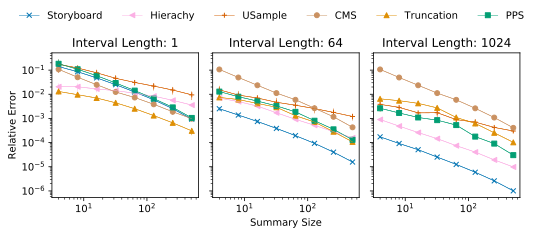

In [98]:
sketch_names = [
    "cooperative", 
    "dyadic_b2", 
    "random_sample", 
    "cms_min", 
    "truncation", 
    "pps"]
sketch_sizes = [4, 8, 16, 32, 64, 128, 256, 512]
# dataset_name = "zipf1p1_10M"
dataset_name = "caida_10M"
granularity = 2048
item_agg = "max"
query_agg = "mean"

query_lengths = [1, 64, 1024]

fig, axs = plt.subplots(figsize=(7.5,3.0), nrows=1, ncols=3, sharey=True, dpi=100)
# plt.subplots_adjust(wspace=.1)

di = 0

for query_len in query_lengths:
    query_size_plot(
        dataset_name,
        granularity,
        sketch_names,
        sketch_sizes,
        query_len = query_len,
        item_agg=item_agg,
        query_agg=query_agg,
        ax=axs[di],
        normalize=True
    )
    di += 1

axs[1].set_xlabel("Summary Size")
axs[0].set_ylabel("Relative Error")

fig.tight_layout()
lgd = axs[0].legend(frameon=False, loc='upper center', bbox_to_anchor=(1.5, 1.35), ncol=6)
fname = "output/plots/linear_freq_size.pdf"
fig.savefig(fname, bbox_extra_artists=(lgd,), bbox_inches='tight')